#### 1. Perform exploratory data analysis on the dataset.

<span style = "color:blue">
1. Abnormally large quote prices / quote sizes / trade quantities are from: 1) pre-market quotes or trades, 2) one-sided quotes, or 3) some quotes associated with 000021.SZ.
</span>

<span style = "color:blue">
2. The test assumes that there is only one bid price and there is only one ask price at each timestamp. However, this might not be true in reality, where multiple bid prices and ask prices can exist at any given time. In other words, in this test we only focus on fresh quotes.
</span>

In [148]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
# import data
quotes = pd.read_csv('quote.csv')
trades = pd.read_csv('trade.csv')

In [150]:
# clean data
# one-sided quotes
quotes.loc[quotes['bid_size'] < 0.1, 'bid_price'] = float('nan')
quotes.loc[quotes['ask_size'] < 0.1, 'ask_price'] = float('nan')
# aggregate to timestamp
quotes = quotes.groupby(['symbol', 'recv_time']).agg({'bid_price': 'mean', 'bid_size': 'sum', 'ask_price': 'mean', 'ask_size': 'sum'}).reset_index()
trades = trades.groupby(['symbol', 'recv_time']).agg({'trade_price': 'mean', 'trade_qty': 'sum'}).reset_index()
# timestamp -> China Standard Time
quotes['date_time'] = pd.to_datetime(quotes['recv_time'], unit = 'us') + pd.DateOffset(hours = 8)
quotes['hour'] = quotes['date_time'].dt.hour
quotes['minute'] = quotes['date_time'].dt.minute
quotes['second'] = quotes['date_time'].dt.second
trades['date_time'] = pd.to_datetime(trades['recv_time'], unit = 'us') + pd.DateOffset(hours = 8)
trades['hour'] = trades['date_time'].dt.hour
trades['minute'] = trades['date_time'].dt.minute
trades['second'] = trades['date_time'].dt.second
# restrict to market hours
quotes = quotes[quotes['date_time'].between('2020-10-09 09:30:00', '2020-10-09 15:00:00')]
trades = trades[trades['date_time'].between('2020-10-09 09:30:00', '2020-10-09 15:00:00')]
# drop outliers / potential data errors
quotes = quotes[quotes['bid_price'].isna() | (quotes['bid_price'] < 1000)]
quotes = quotes[quotes['ask_price'].isna() | (quotes['ask_price'] < 1000)]
# variables used by later analyses
quotes['mid_price'] = 0.5 * quotes['bid_price'] + 0.5 * quotes['ask_price']
quotes['spread'] = quotes['ask_price'] - quotes['bid_price']

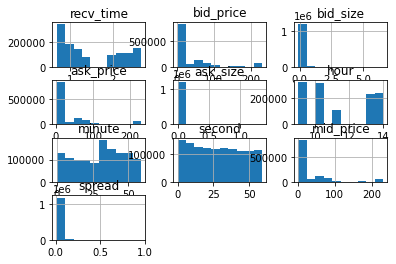

In [151]:
# exploratory analyses on quotes
# quotes.describe()
# quotes.sort_values(['bid_size']).head()
quotes.hist()
plt.show()

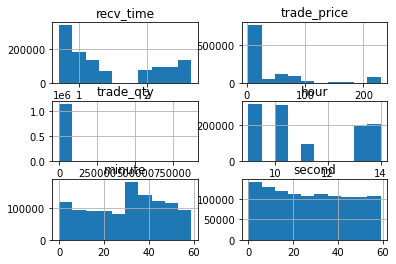

In [152]:
# exploratory analyses on trades
# trades.describe()
# trades.sort_values(['trade_qty']).tail()
trades.hist()
plt.show()

#### 2. Find the stock with the largest trade volume between 09:30 to 10:00 (China Standard Time). Show the corresponding largest volume as well.

In [153]:
trades_0930_1000 = trades[trades['date_time'].between('2020-10-09 09:30:00', '2020-10-09 10:00:00')]
trades_0930_1000.groupby(['symbol']).sum().sort_values(['trade_qty']).tail(1)[['trade_qty']]

,trade_qty
symbol,
002610.SZ,101160467.0


#### 3. Find the stock with the largest trade volume within each 30-minute window from 09:30 to 15:00, i.e., 09:30 to 10:00, ..., 14:30 to 15:00 (China Standard Time). Show the corresponding largest volume as well.

In [154]:
trades['window_30m'] = trades['date_time'].dt.hour + trades['date_time'].dt.minute // 30 * 0.5
trades.groupby(['window_30m', 'symbol']).sum().sort_values(['window_30m', 'trade_qty']).groupby(['window_30m']).tail(1)[['trade_qty']]

,,trade_qty
window_30m,symbol,
9.5,002610.SZ,101160467.0
10.0,002610.SZ,49700140.0
10.5,002610.SZ,20134980.0
11.0,002610.SZ,20923687.0
13.0,002610.SZ,12440400.0
13.5,002610.SZ,7673800.0
14.0,002610.SZ,10989000.0
14.5,002610.SZ,14776512.0


#### 4. Find the top 5 stocks with the largest total trade volume. Plot the series of per-minute trade volume for each of these 5 stocks.

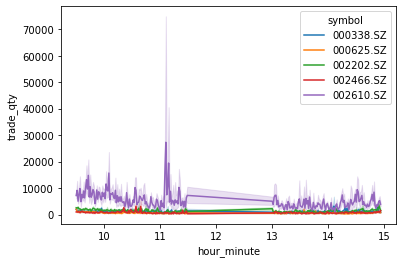

In [155]:
top5 = trades.groupby(['symbol']).sum().sort_values(['trade_qty']).tail(5).reset_index()
trades_top5 = trades.merge(top5[['symbol']], how = 'inner', on = 'symbol')
trades_top5.groupby(['symbol', 'hour', 'minute']).sum().reset_index()
trades_top5['hour_minute'] = trades_top5['hour'] + trades_top5['minute'] / 60
sns.lineplot(data = trades_top5, x = "hour_minute", y = "trade_qty", hue = "symbol")
plt.show()

#### 5. Compute the mean spread for symbol 000021.SZ on quotes. Here spread(t) = ask_price(t) - bid_price(t), where t is the timestamp.

In [156]:
quotes_21 = quotes[quotes['symbol'] == '000021.SZ']
round(quotes_21['spread'].mean(), 3)

0.014

#### 6. Compute the median spread for symbol 000021.SZ on trades. Here spread(t) = ask_price(t) - bid_price(t), where t is the timestamp. Hint: you need to merge quotes and trades to find out bid_price and ask_price of the same symbol at the time when the trade happens.

In [157]:
quotes_21 = quotes[quotes['symbol'] == '000021.SZ']
trades_21_tradetimes = trades[trades['symbol'] == '000021.SZ'].groupby(['recv_time']).sum()
result = quotes_21.merge(trades_21_tradetimes[[]], how = 'inner', left_on = 'recv_time', right_index = True)
round(result['spread'].mean(), 3)

0.013

#### 7. Compute the t-stat of 5-minute open-to-open log-returns for each stock on quotes. The null hypothesis is that the mean of those log-returns is 0. Several steps are involved to solve this problem:
#### a. Group the quotes into multiple 5-minute windows.
#### b. Obtain the series of open_mid_price (i.e. the first mid_price you observe in each window), where mid_price(t) = 0.5 * (bid_price(t) + ask_price(t))).
#### c. Calculate the t-stat of 5-minute open-to-open log-returns, where log-return(this_window) = log(open_mid_price(next_window) / open_mid_price(this_window)).

In [158]:
# construct categorical variable indicating 5-minute windows
quotes['window_5m'] = quotes['date_time'].dt.hour + quotes['date_time'].dt.minute // 5 / 12
# filter to open quotes only
quotes_window_5m = quotes.sort_values(['symbol', 'recv_time']).groupby(['symbol', 'window_5m']).head(1)
# get forward open quotes
quotes_window_5m['f1_mid_price'] = quotes_window_5m.groupby(['symbol'])['mid_price'].shift(-1)
# calculate return
quotes_window_5m['log_return'] = np.log(quotes_window_5m['f1_mid_price'] / quotes_window_5m['mid_price'])
# calculate t-stat
def tstat(s):
    if s.empty:
        return None
    else:
        s = s.dropna()
        return s.mean() / s.std() * ((s.count() / (s.count() - 1))**(1/2))
quotes_window_5m.groupby(['symbol'])['log_return'].agg([tstat]).round(2)

,tstat
symbol,
000021.SZ,0.12
000333.SZ,0.01
000338.SZ,0.07
000402.SZ,0.13
000540.SZ,0.04
000625.SZ,0.09
000703.SZ,0.18
000729.SZ,0.08
000739.SZ,-0.17


#### 8. Train a model that best predicts the 10-second log-returns of mid_price on quotes and trades. Here mid_price(t) = 0.5 * (bid_price(t) + ask_price(t)) and 10-second log-return(t) = log(mid_price(t+10 seconds) / mid_price(t)). Please split the dataset into a 60%-40% partition for training and test sets. Describe the fitted model (target variable, features, summary statistics, model choice and hyper-parameters tuning, if any), present both training and test performance, and compare different approaches if you try multiple models.
#### Hint: you might want to consider shifting price and using merge_asof to compute log-returns.

<span style = "color:blue">
1. First and foremost, it is important to clarify the nature of this predictive problem. I assume that the problem is: what is the 10-second return of any given stock on any given day? This sets some key restrictions on our model. Most importantly, we cannot rely on stock fixed effects (ticker dummies), because, for example, the fact that ABC has consistently negative returns on 10/09/2020 does not mean that ABC will have negative returns on other days. Even though stock fixed effects are likely to increase predictive accuracy in this particular dataset we analyze, it should not hold validity externally on any other day. On the other hand, we can still use time fixed effects (hour dummies), because the aggregate market can have dynamics that repeat from day to day, e.g. high (low) return in the morning (afternoon).
</span>

<span style = "color:blue">
2. What models should we consider? I consider three models: partial least squares regression (PLS), random forest regression (RF), and feedforward neural network (NN). RF and NN are known to be effective predictive models that work well with high dimensionality, nonlinearity, and interactions. PLS is interesting because it works primarily through dimensionality reduction. Therefore, comparing PLS with RF and NN would shed light on the importance of nonlinearity and interaction in this particular predictive problem.
</span>

<span style = "color:blue">
3. What features should we include in our model? I consider four sets of features: 1) lagged returns, which capture momentum and reversal effects; 2) (lagged) spreads, which capture liquidity effects; 2) (rolling) quote quantities and trade volumes, which capture flow and sentiment effects; 4) overall market dynamics, e.g. returns and volumes; 5) time fixed effects (see 1st bullet point above for more discussion on the exclusion of stock fixed effects).
</span>

<span style = "color:blue">
4. How should we select hyperparameters? I use k-fold cross-validation, i.e. randomly split the data into k folds, test (train) on the kth fold (the other folds), and select the hyperparameters that produce the highest test performance (within the train data). For PLS, the only hyperparameter is number of components. For RF, the key hyperparameters are number of trees and tree depth. For NN, the key hyperparameters are number and size of hidden layers.
</span>

<span style = "color:blue">
5. How should split the data into training set vs test set? I use random sampling of tickers. In other words, the training set contains a set of tickers and all their quotes and trades over time, and the test set contains all the other tickers and all their quotes and trades over time. This way of splitting makes the training set and the test set most independent of each other.
</span>

<span style = "color:blue">
6. In terms of results, none of the models I fit is successful (compared to a constant guess), since out-of-sample test R2 is very small or negative across all models. If given more time, I would look into for which stocks and which hours do the models perform the best/worst. According to RF, the most important variables are lagged variables, i.e. momentum and reversal effects.
</span>

<span style = "color:blue">
7. One minor point. The question suggests doing analysis on the timestamp level, which I follow. However, the analysis can be done alternatively with data that aggregate quotes and trades at 10-second intervals. This alternative approach has the benefit of having (more) independent observations (10-second return from t to t+10 is very correlated with 10-second return from t+1 to t+11) and having more balance (some 10-second intervals can have much more action than others).
</span>

In [159]:
# forward 10-second log return
quotes['f_recv_time'] = quotes['recv_time'] + 10 * 10**6
quotes.sort_values(['recv_time'], inplace = True)
quotes = pd.merge_asof(
    quotes,
    quotes[['symbol', 'recv_time', 'mid_price']].rename(columns = {'recv_time': 'f_recv_time', 'mid_price': 'f_mid_price'}),
    on = 'f_recv_time',
    by = 'symbol',
    tolerance = 10**6,
    direction = 'nearest'
)
quotes['f10_log_return'] = np.log(quotes['f_mid_price'] / quotes['mid_price'])

In [160]:
# feature engineering
# lagged 10s, 1m, 5m, 1h variables
for l in [10, 60, 300, 3600]:
    quotes['l{}_recv_time'.format(l)] = quotes['recv_time'] - l * 10**6
    quotes.sort_values(['recv_time'], inplace = True)
    quotes = pd.merge_asof(
        quotes,
        quotes[['symbol', 'recv_time', 'mid_price', 'spread']].rename(columns = {'recv_time': 'l{}_recv_time'.format(l), 'mid_price': 'l{}_mid_price'.format(l), 'spread': 'l{}_spread'.format(l)}),
        on = 'l{}_recv_time'.format(l),
        by = 'symbol',
        tolerance = 10**6,
        direction = 'nearest'
    )
    quotes['l{}_log_return'.format(l)] = np.log(quotes['mid_price'] / quotes['l{}_mid_price'.format(l)])
# rolling 10s, 1m, 5m, 1h variables
quotes.sort_values(['symbol', 'recv_time'], inplace = True)
for l in [10, 60, 300, 3600]:
    quotes['r{}_bid_size'.format(l)] = quotes.groupby(['symbol'])['bid_size'].rolling(l).sum().reset_index(drop = True)
    quotes['r{}_ask_size'.format(l)] = quotes.groupby(['symbol'])['bid_size'].rolling(l).sum().reset_index(drop = True)
# time dummies
quotes['morning'] = 0
quotes.loc[quotes['hour'] < 12, 'morning'] = 1
# market variables, e.g. weighted average of returns at each minute, ran out of time

In [161]:
# final dataset
final = quotes[
    ['symbol', 'recv_time', 'morning'] +
    ['f10_log_return', 'l10_log_return', 'l60_log_return', 'l300_log_return', 'l3600_log_return'] +
    ['spread', 'l10_spread', 'l60_spread', 'l300_spread', 'l3600_spread'] +
    ['r10_bid_size', 'r60_bid_size', 'r300_bid_size', 'r3600_bid_size'] + 
    ['r10_ask_size', 'r60_ask_size', 'r300_ask_size', 'r3600_ask_size']
]
final = final.dropna()
final.describe(include = 'all')

,symbol,recv_time,morning,f10_log_return,l10_log_return,l60_log_return,l300_log_return,l3600_log_return,spread,l10_spread,...,l300_spread,l3600_spread,r10_bid_size,r60_bid_size,r300_bid_size,r3600_bid_size,r10_ask_size,r60_ask_size,r300_ask_size,r3600_ask_size
count,250935,2.509350e+05,250935.000000,250935.000000,250935.000000,250935.000000,250935.000000,250935.000000,250935.000000,250935.000000,...,250935.000000,250935.000000,2.509350e+05,2.509350e+05,2.509350e+05,2.509350e+05,2.509350e+05,2.509350e+05,2.509350e+05,2.509350e+05
unique,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,000625.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,25116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.602218e+15,0.545440,-0.000017,-0.000014,0.000079,0.000164,0.003597,0.016871,0.016196,...,0.016526,0.019476,9.506193e+05,5.692576e+06,2.813350e+07,3.028911e+08,9.506193e+05,5.692576e+06,2.813350e+07,3.028911e+08
std,NaN,6.525279e+09,0.497932,0.000792,0.000807,0.001527,0.003092,0.011731,0.025371,0.022939,...,0.023548,0.030685,2.854762e+06,1.665440e+07,7.821924e+07,7.503602e+08,2.854762e+06,1.665440e+07,7.821924e+07,7.503602e+08
min,NaN,1.602211e+15,0.000000,-0.007590,-0.007590,-0.011451,-0.015297,-0.044108,0.010000,0.010000,...,0.010000,0.010000,3.360000e+02,6.000000e+03,7.000300e+04,2.769940e+06,3.360000e+02,6.000000e+03,7.000300e+04,2.769940e+06
25%,NaN,1.602212e+15,0.000000,-0.000110,-0.000088,-0.000626,-0.001269,-0.003469,0.010000,0.010000,...,0.010000,0.010000,2.860000e+04,2.412660e+05,1.601487e+06,2.412986e+07,2.860000e+04,2.412660e+05,1.601487e+06,2.412986e+07
50%,NaN,1.602214e+15,1.000000,0.000000,0.000000,0.000000,0.000000,0.002117,0.010000,0.010000,...,0.010000,0.010000,1.138160e+05,8.441000e+05,4.806600e+06,5.973501e+07,1.138160e+05,8.441000e+05,4.806600e+06,5.973501e+07
75%,NaN,1.602225e+15,1.000000,0.000132,0.000132,0.000635,0.001499,0.010521,0.010000,0.010000,...,0.010000,0.020000,4.775000e+05,2.949000e+06,1.583225e+07,1.888085e+08,4.775000e+05,2.949000e+06,1.583225e+07,1.888085e+08


In [162]:
# split data into training set vs test set
from sklearn.model_selection import train_test_split
symbols = final.groupby(['symbol'])['recv_time'].max().reset_index()
train_symbols, test_symbols = train_test_split(symbols, test_size = 0.4, random_state = 1234)
train = final.merge(train_symbols[['symbol']], how = 'inner', on = 'symbol')
test = final.merge(test_symbols[['symbol']], how = 'inner', on = 'symbol')
y_train = train['f10_log_return']
X_train = train.drop(columns = ['f10_log_return', 'symbol'])
y_test = test['f10_log_return']
X_test = test.drop(columns = ['f10_log_return', 'symbol'])

In [163]:
# prepare for fitting models
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
models = dict()

In [164]:
# Partial Least Squares (PLS)
# import libraries
from sklearn.cross_decomposition import PLSRegression
# find hyperparameters
pls_models = dict()
for n_components in [5, 10, 15]:
    pls = PLSRegression(n_components = n_components)
    pls_models[n_components] = np.mean(cross_val_score(pls, X_train, y_train, scoring = 'r2', cv = KFold(shuffle = True, random_state = 1234)))
pls_models

{5: 0.010858898990359056, 10: 0.011022704036521658, 15: 0.01106750140110253}

In [165]:
# performance on test set
pls = PLSRegression(n_components = 15)
pls.fit(X_train, y_train)
models['pls'] = [r2_score(y_train, pls.predict(X_train)), r2_score(y_test, pls.predict(X_test))]
models

{'pls': [0.01133994916316372, -0.021536886619887508]}

In [166]:
# Random Forest (RF)
# import libraries
from sklearn.ensemble import RandomForestRegressor
# find hyperparameters
rf_models = dict()
for n_estimators in [50, 100]:
	for max_depth in [3, 5]:
		rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, random_state = 1234)
		rf_models[(n_estimators, max_depth)] = np.mean(cross_val_score(rf, X_train, y_train, scoring = 'r2', cv = KFold(shuffle = True, random_state = 1234)))
rf_models

{(50, 3): 0.050815314395221155,
 (50, 5): 0.10170039750165705,
 (100, 3): 0.050762491340188044,
 (100, 5): 0.10190732099913309}

In [167]:
# performance on test set
rf = RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state = 1234)
rf.fit(X_train, y_train)
models['rf'] = [r2_score(y_train, rf.predict(X_train)), r2_score(y_test, rf.predict(X_test))]

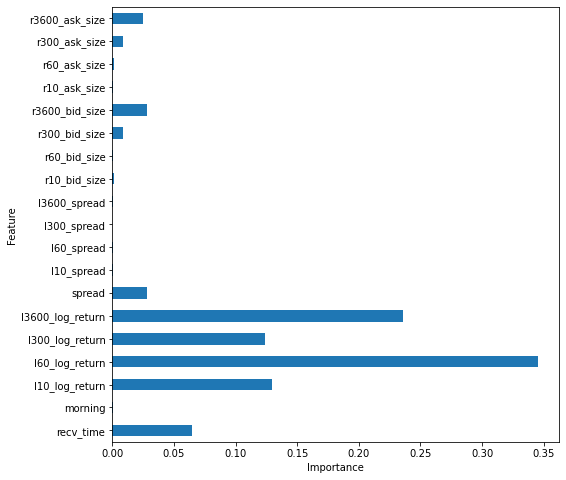

In [168]:
# feature importance
pd.DataFrame.from_dict(dict(zip(X_train.columns, rf.feature_importances_)), orient = 'index').iloc[:,0].plot(kind = 'barh', figsize = (8,8))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [169]:
# Feedforward Neural Network (NN)
# import libraries
from sklearn.neural_network import MLPRegressor
# find hyperparameters
nn_models = dict()
for hidden_layer_sizes in [(5, ), (10, ), (15, )]:
    nn = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes)
    nn_models[hidden_layer_sizes] = np.mean(cross_val_score(nn, X_train, y_train, scoring = 'r2', cv = KFold(shuffle = True, random_state = 1234)))
nn_models

{(5,): -1.5395634231569298e+24,
 (10,): -4.46298868546077e+28,
 (15,): -1.7202509888525264e+28}

In [170]:
# performance on test set
nn = MLPRegressor(hidden_layer_sizes = (10, ))
nn.fit(X_train, y_train)
models['nn'] = [r2_score(y_train, nn.predict(X_train)), r2_score(y_test, nn.predict(X_test))]

In [171]:
# performance across models
pd.DataFrame.from_dict(models).rename(index = {0: 'Training R2', 1: 'Test R2'})

,pls,rf,nn
Training R2,0.011340,0.104444,-1.350951e+24
Test R2,-0.021537,0.007349,-1.150233e+24
